# Variational AutoEncoder 

Variational AutoEncoder(이하 VAE)는 생성모델 중 하나이다. VAE는 GAN과 더불어 딥러닝 기반 생성모델로 널리 알려져 있으며, 2014년에 발표된 다음 두 논문에 기반한 방법이다.

* [Kingma and Welling, Auto-Encoding Variational Bayes, International Conference on Learning Representations (ICLR) 2014.](https://arxiv.org/abs/1312.6114)
* [Rezende, Mohamed and Wierstra, Stochastic Backpropagation and Approximate Inference
in Deep Generative Models. ICML 2014.](https://arxiv.org/abs/1401.4082)


여기서는 Kingma와 Welling이 ICLR 2014에 발표한 논문을 텐서플로우 2.0 기반으로 구현하여 VAE를 이해하도록 한다.

본 문서 이외에도 VAE에 대해 상세히 설명되어 있는 좋은 자료들이 많으니, 각자 시간을 내어 반드시 살펴보도록 하자.

* [PR-010: Auto-Encoding Variational Bayes, ICLR 2014, presented by Junbum Cha](https://youtu.be/KYA-GEhObIs)
* [오토인코더의 모든 것 - 1/3, by 이활석 (Naver D2 세미나)](https://youtu.be/o_peo6U7IRM)
* [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [Conditional Variational Autoencoders, by Isaac Dykeman](http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
* [D.P. Kingma, Variational Inference and Deep Learning: A New Synthesis, Ph.D. Thesis](https://www.dropbox.com/s/v6ua3d9yt44vgb3/cover_and_thesis.pdf?dl=1)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)





## 생성 모델 문제

생성 모델 문제의 목표는 주어진 데이터셋과 유사하면서도 새로운 데이터를 생성해 낼 수 있는 모델을 수립하는 것이다. 확률적인 관점에서 본다면, 확률함수 $p^{*}(x)$를 구하는 문제이며, 해당 확률함수 $p^{*}$로 뽑힌 $x$는 우리가 가지고 있는 데이터셋과 유사해야 한다. 

$$ x \sim p^{*}(x)$$

그런데, 현실적으로 확률함수 $p^{*}(x)$를 알아내는 것은 불가능하다. 

예를 들어, 우리가 다루고자 하는 생성 모델 문제가 사람의 얼굴 영상을 만드는 문제라고 하자. 그럼 $p^{*}(x)$는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 만들어 낼 수 있는 확률함수이고, 해당 확률함수에서 뽑힌(drawn) $x$는 얼굴 영상이다.

### 딥러닝 기반 생성 모델
최근 딥러닝의 발전으로 생성 모델 문제를 데이터셋을 기반으로 한 딥뉴럴넷 학습으로 해결하려는 시도가 활발히 진행되고 있다. VAE와 GAN이 대표적인 예이다.

예를 들어, [CelebA 데이터셋](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)과 같이 유명인들의 얼굴을 찍어 놓은 영상들이  있다면, 이 데이터를 기반으로 한 생성 모델 문제는 새로운 얼굴 영상을 만들어 낼 수 있는 생성 모델 $p_{\theta}(x)$을 수립하는 것이다. 당연히, 우리가 수립하고자 하는 생성 모델은 미지의 진실 확률함수 $p^{*}(x)$를 최대한 잘 근사해야 할 것이다.

$$ p^{*}(x) \approx p_{\theta}(x)$$

이제 생성 모델 $p_{\theta}(x)$를 수립하는 문제를 다음과 같이 데이터 기반으로 한 학습과정으로 설명해 보자.

* 우리가 생성하려는 데이터의 총 집합을 $X$라 하자. 예를 들어 얼굴 생성 문제에서는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 찍은 영상 집합 $X$가 된다.
* 이제, 사람의 얼굴을 찍은 영상 $x$가 있다면, 이 영상은  총 집합 $X$로부터 어떤 확률적인 과정에 의해 뽑힌 것으로 생각하자. 즉, 
$$ x \sim p_{\theta}(x)$$
* 학습에 앞서, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 구조를 정의한다. 즉, 딥뉴럴넷의 구조를 정의한다.
* 학습을 통해, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 최적 파라메터 $\theta$를 학습한다. 즉, 딥뉴럴넷의 파라메터를 업데이트한다.

그런데,  $p_{\theta}(x)$도 역시 직접적으로 알아내는 것은 다루기 힘든(intractable) 문제이다. 하지만 다음과 같은 가정 하에 생성모델을 설계하고 훈련한다면, $p_{\theta}(x)$를 간접적으로 알아내는 것이 가능하다.


### 가정
생성 모델에서는 다음과 같이 데이터에 대해 의미있는 가정을 한다. 

* i.i.d 가정(independent and identical distribution assumption): 총 집합 $X$의 각 원소들을 $p_{\theta}(x)$에 의해 확률적으로 뽑는다면 각 시행은 독립적이며 동일한 분포를 가지게 된다.
* 충분한 양의 학습 데이터셋  $\{x^{(i)}\}_{i=1}^{N}$가 확보되어 있으면, 이 학습 데이터셋은 데이터의 모집합 $X$를 어느정도 대체할 수 있다.

즉, 각 데이터에 대해 동일 분포로부터 발생한 독립적인 사건의 곱으로 생각할 수 있다.

$$ p^{*}(X) \approx p_{\theta}(X) \approx p_{\theta}(\{x^{(i)}\}_{i=1}^{N}) = p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = p_{\theta}(x^{(1)}) \cdots p_{\theta}(x^{(N)}) = \prod_{i=1}^{N}p_{\theta}(x^{(i)}) $$

로그 확률함수를 생각한다면, 다음과 같이 각 데이터의 로그 확률함수에 대한 합으로 생각할 수 있다.

$$\log p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = \log p_{\theta}(x^{(1)}) + \cdots + \log p_{\theta}(x^{(N)}) = \sum_{i=1}^{N} \log p_{\theta}(x^{(i)})$$

얼굴 영상을 만드는 생성 문제에서 i.i.d 가정은 다음과 같이 해석될 수 있다. (independent) 생성 모델로 어떤 영상을 새롭게 만들었다면, 이는 이전에 생성된 혹은 그 이후에 생성될 영상에 영향을 주지 않는다. (identical) 뿐만 아니라 각 영상들은 얼굴에 관한 영상들이다. 즉, 얼굴 생성 모델이 자동차나 고양이 영상을 만들어 내지는 않는다.

In [ ]:
# 클릭할때마다 데이터를 만들어줌
# p*() : 만들어달라 할때마다 만들어주는 주사위

# x <- P(X, Z) # random noise? : Z 가 끼여있다고 생각

# p(a, b) =>  b=n~m시그마  P(x)
# - marginal distirbution
# - : b의 모든 경우의 수에 대하 합을 구함

# -> z에 joint distribution에 marginality를 줘서 없애고 싶음

# network의 세타를 잘 조정해서 잘 생성하는 모방체(p*())를 만들고싶다.
# p() : 네트워크 설계
# 세타 : 학습 파라미터

# task : 사람의 얼굴과 같은 이미지를 만들어내기
# x ~ p세타(z) 
# x : 사람얼굴 - 다른사람 7만장 => independent, 어쨌든 사람얼굴임 => identical distribution

# 독립사건 -> 쪼갤수있음 -> 곱으로 표현가능
# -> log를 취할 수 있다
# 데이터셋의 확률분포에 로그 취한것 = 각각의 확률에 로그 취한것의 합과 같음




## VAE 구조

구조적으로 봤을 VAE는 오토인코더와 거의 유사하다. 

![일반적인 오토인코더 구조](http://ijdykeman.github.io/assets/cvae_figures/ae_diagram.svg)


궁극적으로 오토인코더와 VAE가 다른 점은 latent space에 제한조건이 걸려있는지 여부이다. 

오토인코더는 동일한 훈련 데이터셋에 대해서도 훈련 초기조건에 따라 완전히 다른 latent space를 가지게 학습된다. 바로 이 점 때문에 오토인코더를 생성모델로서 활용할 수 없다. 반면, VAE는 인코더가 만들어내는 latent space를 우리가 원하는 확률모델과 유사한 모양을 가지도록 강제함으로써, 훈련된 VAE의 디코더 부분을 생성모델로 쓸 수 있다.

이러한 아이디어가 어떻게 VAE의 loss 수식에 반영되고, Tensorflow에서 VAE의 loss 수식이 어떻게 코딩에 반영되는지 살펴보도록 하자.




## VAE의 문제 정의

VAE는 생성 모델 문제를 다음과 같이 정의한다.


### Latent parameter $z$의 도입

우리가 찾고자 하는 $p_{\theta}(x)$를 직접 알아내는 것은 불가능하다.  하지만, 아마도 어떤 내제되어 있는 컨트롤 파라메터 $z$가 있어 $p_{\theta}(x)$를 간접적으로 접근할 수 있을 것이다. 즉,

$$ p_{\theta}(x) = \int p_{\theta}(x,z) dz $$

즉, $p_{\theta}(x)$를 곧바로 공략하지 않고, 1) joint probability $p_{\theta}(x, z)$를 알아낸 다음 2) 컨트롤 파라메터 $z$에 대해 적분하여 marginal probability $p_{\theta}(x)$를 알아내도록 하는 접근법을 생각하자.

이제 joint probability $p_{\theta}(x, z)$는 조건부 확률에 의해 다음과 같이 적을 수 있다.

$$ p_{\theta}(x, z) = p_{\theta}(x | z) p_{\theta}(z) $$


$p_{\theta}(x|z)$는 likelihood, $p_{\theta}(z)$는 prior라고 부르는데 그 의미는 다음과 같다.

* $p_{\theta}(z)$ 
  + 문제를 풀려고 하는 사람의 경험이 반영된 확률분포. 
  + 예를 들어, 우리가 풀고자 하는 문제에 컨트롤 가능한 $z$가 있을텐데, 이 $z$가 아마도 특정 확률분포 $p_{\theta}(z)$를 따를 것이라는 믿음. 
  + 알지도 못하는 **컨트롤 파라메터에 대한 확률적 믿음**이라는 의미에서 사건 $x$의 발생과 무관한 사전확률이라고 한다.
* $p_{\theta}(x|z)$
  + 주어진 컨트롤 파라메터 $z$가 있을 때, 데이터 $x$를 만들어 내는 확률분포. 
  + 주어진 latent parameter $z$가 기반하여 데이터 $x$를 추정한다는 의미에서 가능도(likelihood)라고 한다. 
  + 컨트롤 파라메터에 의해 데이터가 만들어지므로, **우리가 만들고자 하는 생성 모델**이 바로 이것이다.



### 컨트롤 가능한 Prior
Prior $p_{\theta}(z)$는 옳든 그르든 우리가 정하면 되는 확률이다. Prior $p_{\theta}(z)$를 컨트롤 가능한 확률분포로 설정하면 편리하기 때문에, VAE에서는 대부분 $p_{\theta}(z)$를 정규분포로 설정한다.

$$ p_{\theta}(z) \sim N(\mu, \sigma)$$

이제, prior $p_{\theta}(z)$를 정하는 문제는 정규분포의 $\mu$와 $\sigma$를 구하는 문제로 바뀌게 된다.


### 생성 모델에 해당하는 likelihood
컨트롤 파라메터 $z$가 주어졌을 때, 이로부터 데이터 $x$를 만드는 확률분포 $p_{\theta}(x | z)$를 알 수 있다면, 생성 문제는 다 해결한 것이다.

그런데, 조금만 생각해 보면 $p_{\theta}(x | z)$를 알아내는게 쉽지 않다는 것을 알 수 있다. 

얼굴 생성 문제로 다시 돌아가 보자. Prior $p_{\theta}(z)$는 앞서 우리가 임의로 정규분포로 가정했다. 즉, 정규분포를 따르는 확률변수 $z$를 하나 뽑은 것이다. 그 다음 뽑힌 $z$를 likelihood $p_{\theta}(x | z)$에 조건으로 주게 되면 얼굴 사진 $x$가 나와야 한다. 그럼, $p_{\theta}(x|z)$는 도대체 어떤 확률함수이길래 이런 마법같은 것을 할 수 있는 것일까?

VAE에서는 likelihood를 뉴럴넷으로 모델링 하고, 주어진 학습 데이터셋을 통해 이 뉴럴넷을 학습함으로써 likelihood $p_{\theta}(x|z)$를 구한다. 

$$ p_{\theta}(x|z) = \textrm{NeuralNet}(z)$$

이 때, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력은 영상이다. 만일 얼굴 데이터셋으로 뉴럴넷을 학습시켰다면, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력 $x$는 얼굴 영상이어야 한다.

In [ ]:
# latent code
# 원래 인풋에 z(random thinking)이 있었는데 없애는거임
# z input을 marginality
# -> 조건부확률로 적을 수 잇음 : x, z 동시에 알아야하지만 z 아는 상태에서 하는것

# given : DNN의 input
# z를 input으로 하는 dnn을 만듦 = > p세타(x|z) : likelyhood
# 인코더해서 나온 z = > p세타(z) : prior

# p(z)를 인코더로부터 만들지 x, 내가 원하는대로 하고싶음
# noraml 분포로 해볼까 = 내가 결정
# => dnn짜면됨

## VAE의 문제 접근 방법

생성 모델에 해당하는 $p_{\theta}(x|z)$를 훈련시키는 모델을 구축하기 위해, 원래 문제 정의로 돌아가 보자.

원래 문제는 $p_{\theta}(x)$를 구하는 것이었다. $p_{\theta}(x)$를 직접 구하기 힘들기 때문에, 컨트롤 가능한 latent parameter $z$를 도입하여 $p_{\theta}(x,z)$ 문제를 푸는 걸로 접근법을 바꾸었다. 하지만 본질은 $p_{\theta}(x)$를 구하는 것이다.

어떤 방식으로 $p_{\theta}(x)$를 구하던지 간에 $p_{\theta}(x)$로 뽑은 $x$는 데이터셋에 있는 데이터들과 유사해야 한다. 즉, 얼굴 데이터셋을 가지고 생성모델을 만들었을 때, 해당 생성모델이 만든 $x$는 얼굴 영상 같이 보여야 한다는 뜻이다.

이러한 현상을 확률적으로 말하자면, $p_{\theta}(x)$가 최대화 되는 것이다.  같은 의미로 로그를 취한 형태인 $\log p_{\theta}(x)$ 역시 마찬가지로 최대화 되어야 한다.


### VAE의 핵심 수식

$\log p_{\theta}(x)$를 다음과 같이 우리가 도입한 컨트롤 가능한 latent parameter $z$와 결부시켜 보자.

$$ \log p_{\theta}(x) = \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] $$

즉, 컨트롤 파라메터 $z$를 랜덤하게 뽑아 이로부터 만들어낸 $\log p_{\theta}(x)$의 기대값은 최대가 되어야 한다. 식을 좀 더 정리하면, 다음과 같다.

$$
\begin{align} \log p_{\theta}(x) 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] \\ 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right] 
  + \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))
\end{align}
$$

수식 전개를 거쳐 마지막에 도출된 $\mathcal{L}_{\theta,  \phi}(x)$에 주목하도록 하자. $\mathcal{L}_{\theta,  \phi}(x)$을 Evidence Lower BOund (이하, ELBO)라 하는데, VAE의 loss를 결정하는 중요한 항이다. 

<!-- 조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p(x)$를 최대화하는 것이다.


* $\mathcal{L}(x)$: Evidence Lower BOund (이하, ELBO)라 불리는 항으로 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물 사이의 연관성을 측정한다.
* $D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))$: 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 측정한다.

 -->

### VAE 수식의 직관적 해석

조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p_{\theta}(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p_{\theta}(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p_{\theta}(x)$를 최대화하는 것이다.

앞서 살펴보았듯이, $\log p_{\theta}(x)$에 대한 수식 전개를 거쳐 결국 다음과 같이 ELBO과  KL의 합으로 도출되었다.

$$ \log p_{\theta}(x) = \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x)) $$

그런데, KL 항은 두 확률분포의 차이, 즉 거리의 개념을 가지고 있기 때문에 항상 0보다 크다. 

따라서, $\log p_{\theta}(x)$을 최대화 하려면 ELBO 항을 최대로 만들어 자연스럽게 KL 항이 최소화 되도록 해야한다.


### ELBO 최대화
ELBO 수식은 다음과 같은 의미를 가진다. 

> $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right]$: 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포  $q_{\phi}(z|x)$ 와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물  $p_{\theta}(x,z)=p_{\theta}(z)p_{\theta}(x|z)$ 사이의 연관성을 측정한다. 

ELBO를 최대화 한다는 의미는 인코더 $q_{\phi}$가 만들어낸 latent variable $z$로 만들어낼 결과물 $p_{\theta}(z)p_{\theta}(x|z)$, 즉 $p_{\theta}(x,z)$와는 관련이 없으면 없을수록 좋다. 당연히도, VAE에서 만들어내는 latent space는 VAE의 결과물과 달라야 하기 때문에 ELBO는 최대화(maximization) 해야하는 것이 말이 된다.

ELBO 수식을 전개하면 다음과 같다.


$$
\begin{align}
\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p(x,z)}{q_{\phi}(z|x)} \right] \right]
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x,z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) + \log p_{\theta}(z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log q_{\phi}(z|x) - \log p_{\theta}(z) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[ \frac{q_{\phi}(z|x)}{p_{\theta}(z)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$

ELBO를 최대화 하는 것은 다음의 두가지 의미를 갖는다.
* $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right]$ 최대화: 이 항은 latent variable로 복구된 결과 $x$에 대한 기대값이다. 이 항을 다른 말로 **reconstruction term**이라 한다. ELBO가 최대화되려면 reconstruction term으로 복구된 결과의 기대값이 높아야 할 것이다. 
* $- D_{\textrm{KL}}(q_{\phi}(z|x) || \log p_{\theta}(z))$ 최대화: 이 항은 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 설명한다. 당연히 그 연관성이 높아야 하므로 $D_{\textrm{KL}}$은 최소로 되어야 하고, $-D_{\textrm{KL}}$는 최대화 되어야 할 것이다. 이 항을 다른 말로 **regularization term**이라 한다. 

### VAE loss 수식

VAE를 훈련할 때 쓰이는 loss 함수는 ELBO를 최대화 하는 방향이어야 한다. 일반적으로 loss는 최소화 되도록 설계되기 때문에, VAE의 loss는 다음과 같다.

$$ 
\begin{align}
\textrm{VAE loss} 
&= -\textrm{ELBO} \\
&= - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p(x|z) \right] + D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$



<!-- ## 2.2 The variational bound
각 데이터 $x^{(i)}$에 대한 marginal likelihood는 다음과 같다.


$\log p_{\theta}(x^{(i)}) = D_{\textrm{KL}}(q_\phi(z|x^{(i)}) || p_{\theta}(z|x^{(i)})) + \mathcal{L}(\theta, \phi, x^{(i)})$

오른쪽 항에 2개의 텀이 있는데 
* 하나는 true posterior와 approximation의 차이를 재는 KL diverence이고,
* 다른 하나는 ELBO라 불리우는 evidence lower bound이다.

KL은 음수가 아니기 때문에 각 데이터의 marginal likelihood 와 ELBO는 다음의 상관관계를 가진다.

$$\log p_{\theta}(x^{(i)}) \geq \mathcal{L}(\theta, \phi, x^{(i)}) = \mathbb{E}_{q_{\phi}(z|x)}[-\log q_{\phi}(z|x) + \log p_{\theta}(x,z)]$$


ELBO에 관해서만 다시 수식을 정리하면,

$$\mathcal{L}(\theta, \phi, x^{(i)}) = -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


주목해야할 것은 ELBO $\mathcal{L}(\theta, \phi, x^{(i)}) $이 variational parameter $\phi$와 generative parameter $\theta$에 모두 연관되어 있다는 것이다.  따라서, 두 파라메터에 대해 각각 미분가능함을 보이고 최적화하는 방식이 필요하다.  


그런데, variational parameter $\phi$에 대한 단순한 Monte Carlo gradient estimator는 다음과 같이

$$\nabla_\phi \mathbb{E}_{q_{\phi}(z)}[f(z)] = \mathbb{E}_{q_{\phi}(z)} [f(z) \nabla_{q_{\phi}(z)}\log q_\phi(z)]  \simeq \frac{1}{L} \sum_{l=1}^{L} f(z) \nabla_{q_{\phi}(z)} \log q_\phi(z)$$,
where 
$$ z^{(l)} \sim q_{\phi}(z|x^{(i)})$$

인데, [BJP12]에서 밝혀졌듯이 높은 분산을 가져 이 방식은 곤란한다.
 -->



In [ ]:
# 사람얼굴을 만들어내는 주사위 = z라는 랜덤 노이즈가 있다고 가정 그걸 최대한 사람 얼굴에 가깝게 하겠다
# expectation = marginality를 한거다 = z의 weighted everage

# z : encoding 한 z (이미지를 넣어서 만든 z) : 𝑞𝜙(𝑧|𝑥)

# 원래 z가 있음
# p(x|z) = p(x|z)p(z) : z를 아는 경우
# 지금은 x(이미지)를 알고있음 => p(z|x)p(x) : 인코더 파트의 경우임

# =𝔼𝑧∼𝑞𝜙(𝑧|𝑥)[log𝑝𝜃(𝑥)]
# =𝔼𝑧∼𝑞𝜙(𝑧|𝑥)[log[𝑝𝜃(𝑥,𝑧)𝑝𝜃(𝑧|𝑥)]]

# p : 완벽한 이상
# q : 내가 만들고있는 dnn
# z|x : 이미지가 들어오는거임

# 양변에 그냥 곱하고 분리한거임

# 𝔼𝑧∼𝑞𝜙(𝑧|𝑥)[log[𝑞𝜙(𝑧|𝑥)𝑝𝜃(𝑧|𝑥)]] : kl diversions
# 내가만든거, 이상이 얼마나 다른지 비교

# 앞은 엘보?

# log𝑝𝜃(𝑥) 그럴듯한 이미지를 만드는것 = 𝜃,𝜙(𝑥)+𝐷KL(𝑞𝜙(𝑧|𝑥)||𝑝𝜃(𝑧|𝑥)) 이걸로 설명됨
# 뒤에거 = 최대한 작은게 내가 만든것, 이상의 차이가 작다는것임 => 0에 가깝게 만들어야함
# -> 앞에거가 log𝑝𝜃(𝑥) 이 값에 가까워야함
# = 두 확률분포가 비슷하면 뒤에게 0이 됨

# 앞에거 : ~가 무슨짓을 하든간에 독립적 : 분자(입력)가 무엇이든간에 인코더(분자)가 잘하자

# # ELBO
# =𝔼𝑧∼𝑞𝜙(𝑧|𝑥)[log𝑝𝜃(𝑥|𝑧)]−𝐷KL(𝑞𝜙(𝑧|𝑥)||𝑝𝜃(𝑧))
# 뒤에거 p세타 z 확률분포는 최대한 내가 원하는 분포를 (distribution이 최대) 따름
# 앞에건 확률적으로 최대가댐


## Reparameterization Trick

뉴럴넷을 recognition 모델로 쓸 경우, 본 논문에서 제안하는 내용이 variational auto-encoder가 된다.

Variational approximate posterior를 다음과 같이 multivariate Gaussian으로 잡도록 하자.

$$\log q_{\phi} (z | x^{(i)}) = \log\mathcal{N}(z; \mu^{(i)}, \sigma^{2(i)}\mathbf{I})$$


이제 다음의 ELBO 수식의 

$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


우항 첫번째 term은 다음과 같이 쓸 수 있다. 
$$ -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) = \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) $$

여기서 $J$는 latent space의 dimension을 나타낸다.


우항 두번째 term은 Monte Carlo estimation으로 다음과 같이 쓸 수 있다. 
$$\mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)] = \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$

여기서 $L$은 몬테카를로 샘플 개수를 나타낸다.



따라서, ELBO 수식은 다음과 같이 근사될 수 있다.
$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) + \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$


### 원시적인 구현
텐서플로우 2.0 튜토리얼에 나와 있듯이, 위 수식을 그대로 구현하는 방법이 있다. 
* [Reparameterization Trick](https://www.tensorflow.org/alpha/tutorials/generative/cvae#reparameterization_trick)

파이토치의 경우, torch.distributions를 이용하면 구현할 수 있다. 


In [ ]:
# 분포와 이상을 맞추고싶음 
# 이상 : 내가 아는(control하고싶은) 분포 : normal 분포임 : 학습할때 임의로 값을 정하는것
# - 평균, 분산 : 대표값임
# 내가 구하는 분포도 평균, 분산이 비슷하게 되면 되는거임 
# 분포가 맞춰지도록 강제하면됨 (back prop~)

# 평가(loss) : 대표값으로 함(평균, 분산)

# 이걸 목표로 reparameterization trick ~~~만들어진것

# x(데이터)를 뭘 넣든지 간에 z를 잘 만들고 싶다 (normal dist 따르게)

# 분포가 맞는지를 설계하는게 없어서 짰어야 하는데 (Reparameterization Trick) 이걸 측정하는 레이어가 생김 -> tensorflow distribution

In [2]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F
import torch.distributions as td                   # torch distribution 임포트
from torch.utils.data import TensorDataset

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm
from torchvision.utils import save_image

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.0+cu118
Torchvision:  0.15.1+cu118


## GPU 동작 확인

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [4]:
batch_size = 100
learning_rate = 0.001
num_epochs = 20

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 237609437.03it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91216636.92it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57786525.71it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18143360.73it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.


In [6]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

print("test dataset")
print_MNIST_data_loader_info(test_loader)

train dataset
>>> dataset length:  600
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32
test dataset
>>> dataset length:  100
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32


## 모델 설계


In [7]:
enc_dim = 2
c_dim = 10

In [98]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.input = nn.Flatten()
        self.fc1   = nn.Linear(784+c_dim, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4_1 = nn.Linear(64, enc_dim)
        self.fc4_2 = nn.Linear(64, enc_dim)

        self.fc5 = nn.Linear(enc_dim+c_dim, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 784)

    def encoder(self, x, c):
        x       = self.input(x)
        x = torch.cat([x, c], dim=1)
        x       = F.relu(self.fc1(x))
        x       = F.relu(self.fc2(x))
        x       = self.fc3(x)
        mean    = self.fc4_1(x)
        log_var = self.fc4_2(x)

        return mean, log_var

    def decoder(self, z, c):
        z = torch.cat([z, c], dim=1)
        z = F.relu(self.fc5(z))
        z = F.relu(self.fc6(z))
        z = F.relu(self.fc7(z))
        z = torch.sigmoid(self.fc8(z))

        return z

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1,784), c)

        std = log_var.exp().pow(0.5)                    # logvar to std
        q_z = td.normal.Normal(mu, std)                 # create a torch distribution
        z = q_z.rsample()                               # sample with reparameterization

        return self.decoder(z, c), q_z

cvae = CVAE().to(device)
print(cvae)

CVAE(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=794, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=2, bias=True)
  (fc4_2): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=12, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)


In [99]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
from torchinfo import summary

summary(cvae, [(batch_size,1, 28, 28), (batch_size, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [100, 784]                --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 256]                203,520
├─Linear: 1-3                            [100, 128]                32,896
├─Linear: 1-4                            [100, 64]                 8,256
├─Linear: 1-5                            [100, 2]                  130
├─Linear: 1-6                            [100, 2]                  130
├─Linear: 1-7                            [100, 64]                 832
├─Linear: 1-8                            [100, 128]                8,320
├─Linear: 1-9                            [100, 256]                33,024
├─Linear: 1-10                           [100, 784]                201,488
Total params: 488,596
Trainable params: 488,596
Non-trainable params: 0
Total mult-adds (M): 48.86
Input size (MB): 0.32
Forward

GT label: 0
torch.Size([1, 1, 28, 28]) torch.Size([1, 10])


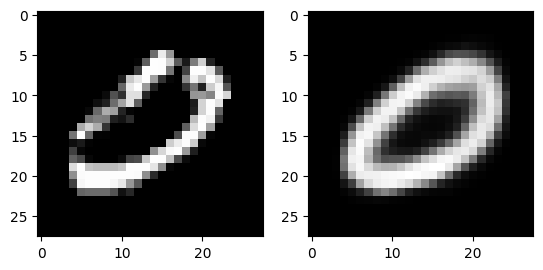

In [40]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def make_one_hot_labels(label):
  if not isinstance(label, torch.Tensor):
    label = torch.tensor([label], device=device)
  label     = label.view(label.shape[0], 1).to(device)
  one_hot_labels = torch.zeros(label.shape[0], c_dim, device=device).scatter(1, label, 1)
  C         = one_hot_labels.to(device)
  return C


def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)
  X         = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  C = make_one_hot_labels(label)
  print(X.shape, C.shape)
  Y_pred, _ = cvae(X, C) 
  Y_pred    = Y_pred.view(1, 28, 28)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

### 테스트를 위한 임시 loader 생성

In [41]:
tmp_loader = DataLoader(dataset=train_dataset,
                          batch_size=60000,
                          shuffle=True)

In [42]:
batch_images, batch_labels = next(iter(tmp_loader))
batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
print(batch_labels)
C = make_one_hot_labels(batch_labels)
print(C.shape)
enc_mean, enc_var = cvae.encoder(batch_images, C)

if use_cuda:  
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample()                              
  y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28).to(device)

else:
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample()  
  y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28)

print(y.shape)

tensor([2, 0, 5,  ..., 3, 1, 3], device='cuda:0')
torch.Size([60000, 10])
torch.Size([60000, 1, 28, 28])


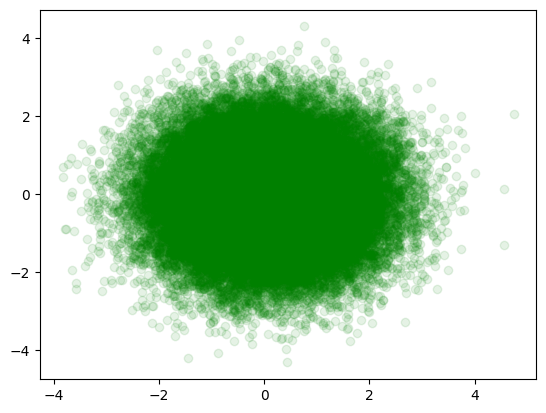

In [43]:
import matplotlib.pyplot as plt

pt = z.cpu().detach().numpy()

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

**VAE Loss Function**

$$ 
\begin{align}
\textrm{VAE loss} 
&= -\textrm{ELBO} \\
&= - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p(x|z) \right] + D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$

In [44]:
# optimizer,loss 설정
def criterion(x_hat, x, q_z):
    # Reconstruction Loss : 입력 데이터를 잘 복원할 수 있도록 하는 손실 함수
    #                       출력 이미지와 입력 이미지의 차이를 최소화
    BCE = F.binary_cross_entropy(x_hat, x.view(-1,784), reduction='sum')
    p_z = td.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
    # Regularization Loss :  VAE 모델이 잠재 변수 공간에서 균일하게 분포하도록 하는 손실 함수
    #                        무작위로 샘플링한 데이터를 입력하고 이를 잘 복원해야 함
    #      - KL-Divergence : 잠재 변수 공간에서 학습된 분포와 정규 분포(Normal Distribution) 사이의 차이를 계산
    #                        이를 통해 잠재 변수 공간에서 균일한 분포를 유지하도록 하며, VAE의 학습을 안정화하는 역할
    KLD = td.kl_divergence(q_z, p_z).sum()
    return BCE + KLD

optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)



In [46]:
for epoch in range(num_epochs):
    now = time.time()
    train_loss = 0
    avg_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images
        C = make_one_hot_labels(batch_labels)
        if use_cuda:
            X = X.to(device)
            C = C.to(device)

        # forward 단계
        # 1. input data를 모델에 통과시킵니다.
        # 2. loss를 계산합니다.
        Y_prediction, q_z = cvae(X, C)
        loss = criterion(Y_prediction, X, q_z)
        # bacward 단계
        # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
        # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
        # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
            
    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
            .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

[Epoch:    1] 	 loss = 182.1265 	 time = 10.4148
[Epoch:    2] 	 loss = 143.7717 	 time = 10.3179
[Epoch:    3] 	 loss = 138.1820 	 time = 9.9630
[Epoch:    4] 	 loss = 135.9023 	 time = 9.8225
[Epoch:    5] 	 loss = 134.4921 	 time = 9.4874
[Epoch:    6] 	 loss = 133.4368 	 time = 10.9783
[Epoch:    7] 	 loss = 132.5756 	 time = 9.8986
[Epoch:    8] 	 loss = 131.9357 	 time = 9.9822
[Epoch:    9] 	 loss = 131.4779 	 time = 9.8960
[Epoch:   10] 	 loss = 131.0497 	 time = 10.5738
[Epoch:   11] 	 loss = 130.6732 	 time = 9.4401
[Epoch:   12] 	 loss = 130.4135 	 time = 9.8133
[Epoch:   13] 	 loss = 130.1262 	 time = 9.8943
[Epoch:   14] 	 loss = 129.8916 	 time = 10.1693
[Epoch:   15] 	 loss = 129.6206 	 time = 9.8774
[Epoch:   16] 	 loss = 129.4283 	 time = 9.3648
[Epoch:   17] 	 loss = 129.2298 	 time = 9.7927
[Epoch:   18] 	 loss = 128.9670 	 time = 10.0751
[Epoch:   19] 	 loss = 128.8134 	 time = 9.9264
[Epoch:   20] 	 loss = 128.6426 	 time = 9.9488
Learning Finished!


In [88]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X         = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  label     = torch.tensor([label])
  label     = label.view(label.shape[0], 1)
  one_hot_labels = torch.zeros(label.shape[0], c_dim).scatter(1, label, 1)
  C         = one_hot_labels.to(device)
  print(X.shape, C.shape)
  Y_pred, _ = cvae(X, C) 
  Y_pred    = Y_pred.view(1, 28, 28)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [91]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X         = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  label     = torch.tensor([label])
  label     = label.view(label.shape[0], 1)
  one_hot_labels = torch.zeros(label.shape[0], c_dim).scatter(1, label, 1)
  C         = one_hot_labels.to(device)
  print(X.shape, C.shape)

  # MNIST 훈련 데이터셋, 테스트 데이터셋을 조건별로 representation p(z)의 분포를 가시화하고 결과에 대해 분석한다
  enc_mean, enc_var = cvae.encoder(X, C)

  if use_cuda:  
    std = enc_var.exp().pow(0.5)
    q_z = td.normal.Normal(enc_mean, std)                
    z = q_z.rsample() 
    C = make_one_hot_labels(label).to(device)                     
    y = cvae.decoder(z, C).reshape(1, 28, 28).to(device)

  else:
    std = enc_var.exp().pow(0.5)
    q_z = td.normal.Normal(enc_mean, std)                
    z = q_z.rsample()  
    C = make_one_hot_labels(label).to(device)                           
    y = cvae.decoder(z, C).reshape(1, 28, 28)


  pt = z.cpu().detach().numpy()
  print(z.shape)
  plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)
  plt.show()


  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(y.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [73]:
batch_images, batch_labels = next(iter(tmp_loader))

batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
C = make_one_hot_labels(batch_labels)
enc_mean, enc_var = cvae.encoder(batch_images, C)

if use_cuda:  
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample() 
  C = make_one_hot_labels(batch_labels).to(device)                     
  y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28).to(device)

else:
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample()  
  C = make_one_hot_labels(batch_labels).to(device)                           
  y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28)

print(y.shape)

torch.Size([60000, 1, 28, 28])


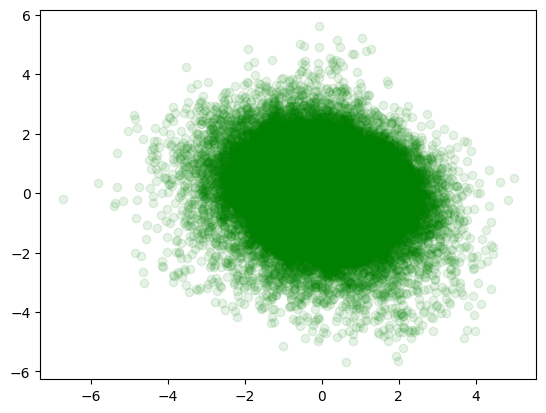

In [74]:
import matplotlib.pyplot as plt

pt = z.cpu().detach().numpy()

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

torch.Size([60000, 2])
torch.Size([60000, 2])


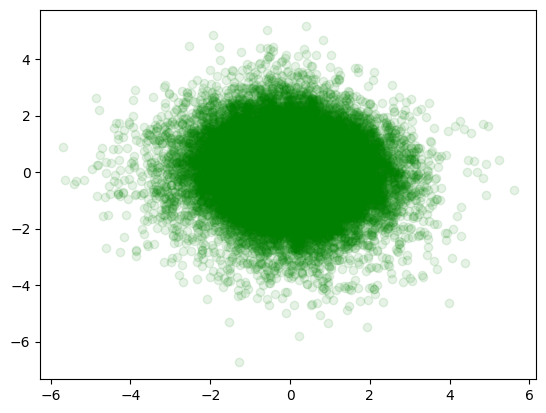

In [76]:
pt = z.view(-1, 3).cpu().detach().numpy()
plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

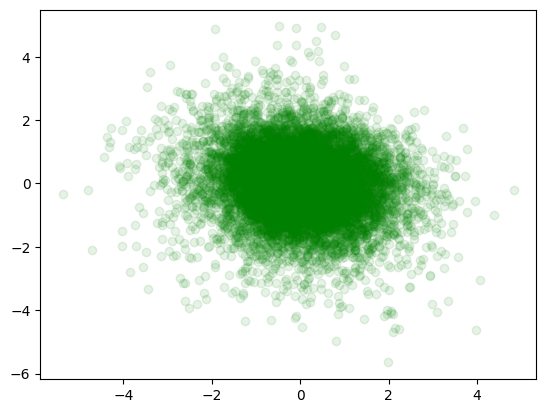

In [81]:
pt = z.view(-1, 10).cpu().detach().numpy()
plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

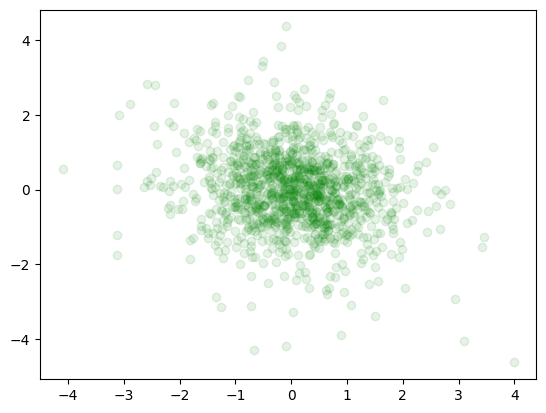

In [80]:

pt = z.view(-1, 100).cpu().detach().numpy()
plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

In [61]:
test_label = 4

if use_cuda:
  z = torch.Tensor([[1.5, -0.3]]).to(device)
  c = make_one_hot_labels(test_label).to(device)
else:
  z = torch.Tensor([[1.5, -0.3]]).to(device)
  c = make_one_hot_labels(test_label).to(device)

y = cvae.decoder(z, c)


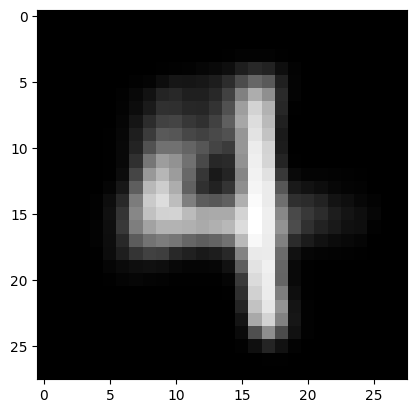

In [62]:
import matplotlib.pyplot as plt

img = y.cpu().detach().numpy()
plt.imshow(img.reshape(28,28), cmap='gray')

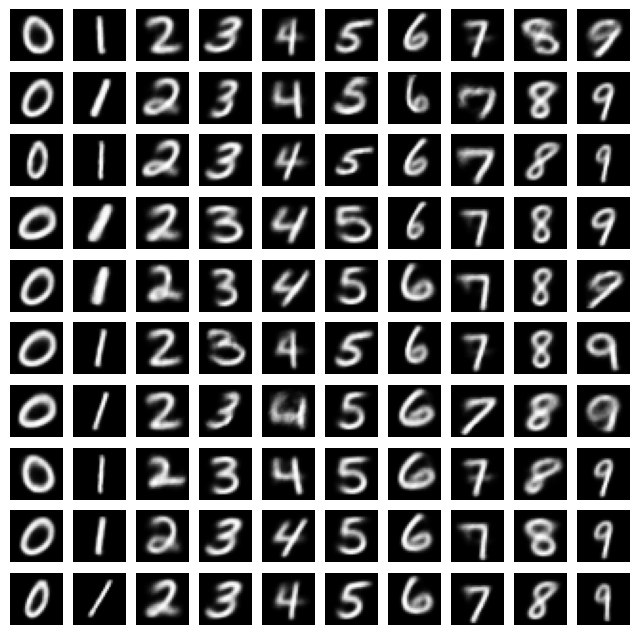

In [96]:
def generate_samples(model, num_samples, device):
    z = td.Normal(0, 1).sample((num_samples, enc_dim)).to(device)
    labels = torch.arange(0, 10).repeat(num_samples // 10).to(device)
    c = make_one_hot_labels(labels)
    with torch.no_grad():
        samples = model.decoder(z, c).cpu()
    return samples

samples = generate_samples(cvae, 100, device)

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        ax.imshow(samples[i*10+j].view(28,28), cmap='gray')
        ax.axis('off')
plt.show()
